In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats

col = 'mutation_coverage'

pitest_figures_out = '../../generated/figures/pitest'
pitest_data_path = '../../generated/code-analysis/pitest.csv'

if not os.path.exists(pitest_data_path):
    raise FileNotFoundError(f"Le fichier {pitest_data_path} n'existe pas. Exécutez d'abord le notebook '../arrange data/Pitest.ipynb' avant.")

df_pitest = pd.read_csv(pitest_data_path)

# Effet d'ordre

In [31]:
from statsmodels.stats.weightstats import ttost_ind

pivot = df_pitest.pivot(index='user', columns='game_mode', values=col)
pivot = pivot.dropna()

groups = df_pitest.drop_duplicates('user')[['user', 'group']]
pivot = pivot.merge(groups.set_index('user'), left_index=True, right_index=True)

pivot['diff'] = pivot.apply(
    lambda row: row['leaderboard'] - row['achievements'] if row['group'] == 'B'
                else row['achievements'] - row['leaderboard'],
    axis=1
)

group_a = pivot[pivot['group'] == 'A']['diff']
group_b = pivot[pivot['group'] == 'B']['diff']

assert len(group_a) == len(group_b), f"Mismatch in sample size for {col}"

_, p_normal_diff_a = stats.shapiro(group_a)
_, p_normal_diff_b = stats.shapiro(group_b)

print(f"Normalité du groupe A : {p_normal_diff_a >= 0.05} - {p_normal_diff_a}")
print(f"Normalité du groupe B : {p_normal_diff_b >= 0.05} - {p_normal_diff_b}")

stat, variance_p_value = stats.levene(group_a, group_b)

print(f"Variance égales : {variance_p_value >= 0.05} - {variance_p_value}")

low_eq_bound = -0.1
high_eq_bound = 0.1
p_value, data1, data2 = ttost_ind(group_a, group_b, low_eq_bound, high_eq_bound, usevar='pooled')

print("p-value :", p_value)

if p_value < 0.05:
    print("H₁ (alternative) : la différence est dans les bornes d’équivalence")
else:
    print(f"H₀ (nulle) : la différence est hors de l’intervalle d’équivalence")

Normalité du groupe A : True - 0.05421049256853437
Normalité du groupe B : True - 0.6873357845103831
Variance égales : True - 0.7753911851022658
p-value : 0.037905736018044124
H₁ (alternative) : la différence est dans les bornes d’équivalence


# Boxplot

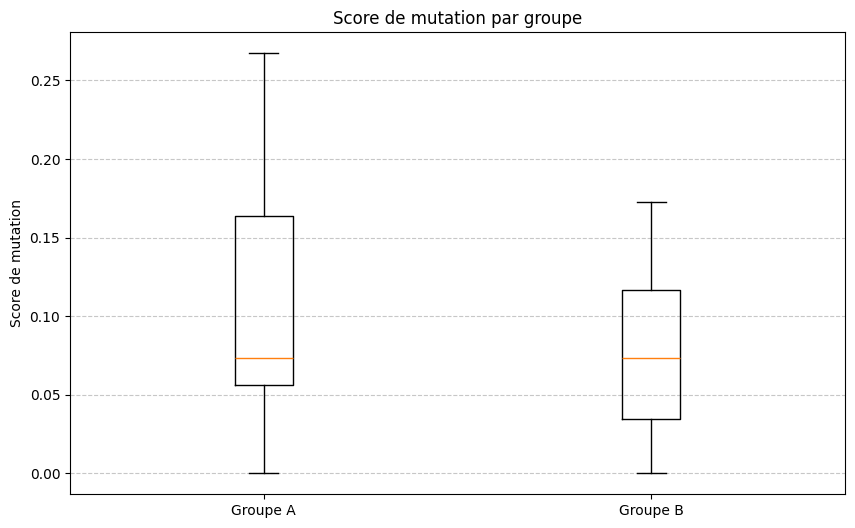

In [34]:
if not os.path.exists(pitest_figures_out):
    os.makedirs(pitest_figures_out)

plt.figure(figsize=(10, 6))
plt.boxplot([
    df_pitest[(df_pitest['group'] == 'A')][col],
    df_pitest[(df_pitest['group'] == 'B')][col]
], tick_labels=['Groupe A', 'Groupe B'])

plt.title('Score de mutation par groupe')
plt.ylabel('Score de mutation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f"{pitest_figures_out}/mutation_score_by_game_mode.pdf")
plt.show()

# Effet de session

In [32]:
from statsmodels.stats.weightstats import ttost_paired
df_rounds = df_pitest.copy()

session1 = df_rounds[df_rounds['session'] == 1][col].values
session2 = df_rounds[df_rounds['session'] == 2][col].values

assert len(session1) == len(session2), f"Mismatch in sample size for {col}"

_, p_shapiro_1 = stats.shapiro(session1)
_, p_shapiro_2 = stats.shapiro(session2)

print(f"Normalité du groupe A : {p_shapiro_1 >= 0.05} - {p_shapiro_1}")
print(f"Normalité du groupe B : {p_shapiro_2 >= 0.05} - {p_shapiro_2}")

stat, variance_p_value = stats.levene(session1, session2)

print(f"Variance égales : {variance_p_value >= 0.05} - {variance_p_value}")

low_eq_bound = -0.1
high_eq_bound = 0.1
p_value, data1, data2 = ttost_paired(session1, session2, low_eq_bound, high_eq_bound)

print("p-value :", p_value)

if p_value < 0.05:
    print("H₁ (alternative) : la différence est dans les bornes d’équivalence")
else:
    print(f"H₀ (nulle) : la différence est hors de l’intervalle d’équivalence")

Normalité du groupe A : True - 0.0627960861526303
Normalité du groupe B : True - 0.2213060649864379
Variance égales : True - 0.8092351755741011
p-value : 0.0001554227324971607
H₁ (alternative) : la différence est dans les bornes d’équivalence


# Boxplot par mode de jeu

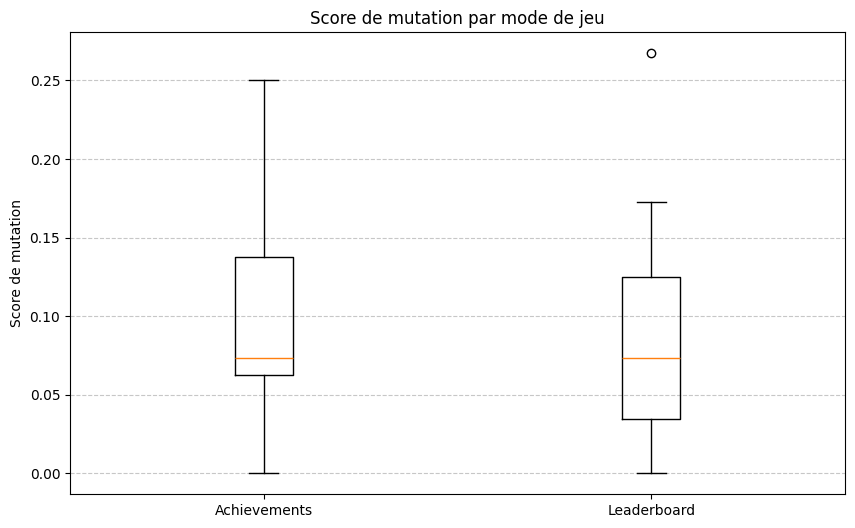

In [17]:
if not os.path.exists(pitest_figures_out):
    os.makedirs(pitest_figures_out)

plt.figure(figsize=(10, 6))
plt.boxplot([
    df_pitest[(df_pitest['game_mode'] == 'achievements')][col],
    df_pitest[(df_pitest['game_mode'] == 'leaderboard')][col]
], tick_labels=['Achievements', 'Leaderboard'])

plt.title('Score de mutation par mode de jeu')
plt.ylabel('Score de mutation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f"{pitest_figures_out}/mutation_score_by_game_mode.pdf")
plt.show()

# Boxplot par session

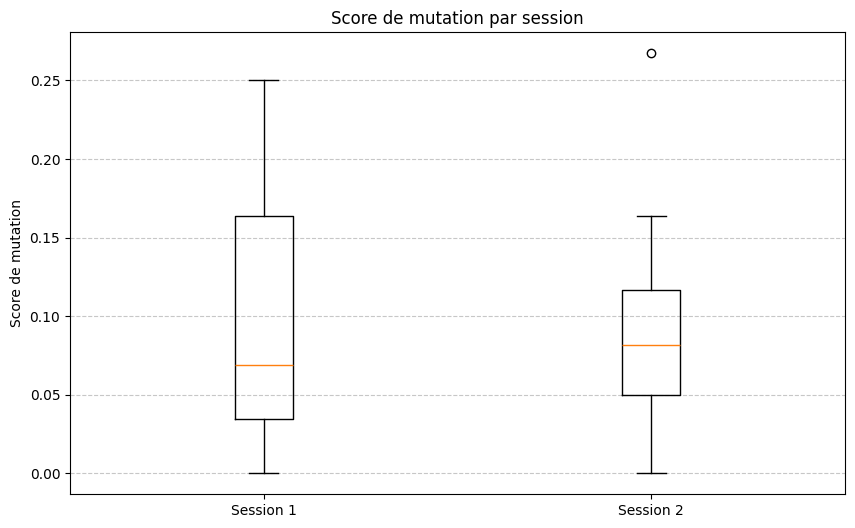

In [12]:
if not os.path.exists(pitest_figures_out):
    os.makedirs(pitest_figures_out)

plt.figure(figsize=(10, 6))
plt.boxplot([
    df_pitest[(df_pitest['session'] == 1)][col],
    df_pitest[(df_pitest['session'] == 2)][col]
], tick_labels=['Session 1', 'Session 2'])

plt.title('Score de mutation par session')
plt.ylabel('Score de mutation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f"{pitest_figures_out}/mutation_score_by_session.pdf")
plt.show()

# Meilleur mode

In [40]:
from notebooks.analysis import tests

alpha = 0.05

leaderboard = df_pitest[df_pitest['game_mode'] == 'leaderboard'][col]
achievements = df_pitest[df_pitest['game_mode'] == 'achievements'][col]

assert len(leaderboard) == len(achievements), f"Mismatch in sample size for {col}"

# Test de normalité
_, p_normal_leaderboard = stats.shapiro(leaderboard)
_, p_normal_achievements = stats.shapiro(achievements)

# Test variance
stat, variance_p_value = stats.levene(leaderboard, achievements)

# Choix du test
if p_normal_leaderboard > 0.05 and p_normal_achievements > 0.05:
    t_stat, p_value = stats.ttest_rel(leaderboard, achievements)
    test = "t-test"
else:
    t_stat, p_value = stats.mannwhitneyu(leaderboard, achievements)
    test = "Mann-Whitney U"

a12 = tests.vargha_delaney_a12(leaderboard, achievements)
a12_label = tests.a12_label(a12)
better_mode = "equals" if a12 == 0.5 else "leaderboard" if a12 > 0.5 else "achievements"

print("p_normal_leaderboard", p_normal_leaderboard)
print("p_normal_achievements", p_normal_achievements)
print("variance_p_value", variance_p_value)

data = [
    col,
    p_normal_leaderboard > 0.05,
    p_normal_achievements > 0.05,
    variance_p_value > 0.05,
    test,
    p_value,
    p_value < alpha,
    a12,
    a12_label,
    better_mode
]

best_mode_df = pd.DataFrame([data], columns=[
    'metric',
    'leaderboard_normal',
    'achievements_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney',
    'better_mode',
])

best_mode_df

p_normal_leaderboard 0.12349810521184001
p_normal_achievements 0.35170720202579175
variance_p_value 0.8536469777782494


,metric,leaderboard_normal,achievements_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney,better_mode
0,mutation_coverage,True,True,True,t-test,0.729275,False,0.460938,Aucun effet,achievements
